In [271]:
import sys, os
from pathlib import Path

# find repo root (parent of "experiments") and add to sys.path
repo_root = Path(__file__).resolve().parents[1] if "__file__" in globals() else Path(os.getcwd()).parents[0]
sys.path.insert(0, str(repo_root))

from eap_fit_hh.inference import EKFTrainer
from eap_fit_hh.utils import compute_comp_xyz, distance, plot_cond_params, compute_eap, build_axial_matrix, build_eap_M

In [272]:
import jaxley as jx
from jaxley.channels import HH
import networkx as nx
from jaxley.io.graph import swc_to_graph, make_jaxley_compatible, from_graph, to_graph
import matplotlib.pyplot as plt
import matplotlib as mpl


import jax.numpy as jnp
import jax.random as random
import tensorflow_probability.substrates.jax as tfp
from jax.tree_util import tree_map
tf = tfp.tf2jax
tfd = tfp.distributions

In [273]:
ncomps_per_branch = 4
nbranches = 3
n_nodes = 2*nbranches
ncomps = nbranches * ncomps_per_branch
comp = jx.Compartment()
branch = jx.Branch(comp, ncomp=ncomps_per_branch)
cell = jx.Cell(branch, parents=[-1, 0, 0])

cell.insert(HH())

cell.set("HH_eNa", 53.0)
cell.set("HH_eK", -107.0)
cell.set("HH_eLeak", -88.5188)
cell.set("v", -88.5188)
cell.set("radius",2.)
cell.set("axial_resistivity", 150.)

ngroups = nbranches
cell.branch(0).add_to_group("gp1")
cell.branch(1).add_to_group("gp2")
cell.branch(2).add_to_group("gp3")

# different param values for each gp
cell.gp1.set("HH_gNa",  0.12)
cell.gp1.set("HH_gK", 0.02)
cell.gp1.set("HH_gLeak", 0.0003)
cell.gp1.set("length",24.0)

cell.gp2.set("HH_gNa",  0.08)
cell.gp2.set("HH_gK", 0.03)
cell.gp2.set("HH_gLeak", 0.0004)
cell.gp2.set("length",50.0)

cell.gp3.set("HH_gNa",  0.10)
cell.gp3.set("HH_gK", 0.008)
cell.gp3.set("HH_gLeak", 0.0001)
cell.gp3.set("length",50.0)

true_cell_positions = compute_comp_xyz(cell)
# surf_areas = get_surface_areas(cell)
# surf_areas_CM2 = surf_areas * 10**(-8)

cell.init_states()

In [274]:
l = 6
x = jnp.arange(jnp.min(true_cell_positions[:,0]), jnp.max(true_cell_positions[:,0])+1, 6.)
y = jnp.linspace(jnp.min(true_cell_positions[:,1]), jnp.max(true_cell_positions[:,1]), l)
y1 = y[0::2]
y2 = y[1::2]
z = jnp.array([5.])
n_col = len(y)
n_points_per_col = len(x)
n_points = n_col*n_points_per_col
n_points_grid1 = len(y1)*n_points_per_col
n_points_grid2 = len(y2)*n_points_per_col
print("num columns", n_col)
print("num points per col", n_points_per_col)
grid1 = jnp.dstack(jnp.meshgrid(x, y1, z)).reshape((n_points_grid1, 3))
grid2 = jnp.dstack(jnp.meshgrid(x, y2, -z)).reshape((n_points_grid2, 3))
grid = jnp.concatenate((grid1, grid2), 0)

true_distances = distance(grid, true_cell_positions) # in um
true_distances_CM = true_distances * 10**(-4)

num columns 6
num points per col 43


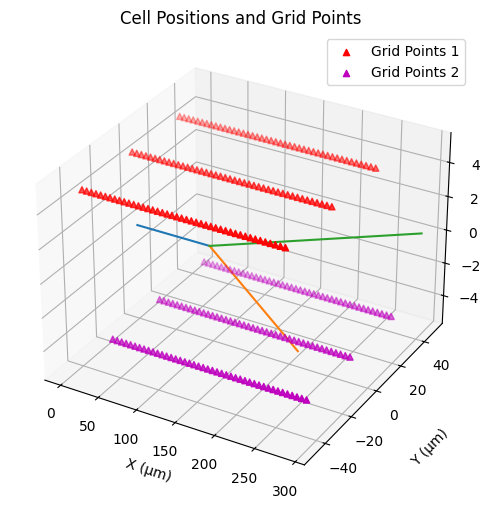

In [275]:
# Create figure and 3D axis
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot compartments with lines
colors = plt.cm.tab10.colors
cell.gp1.vis(ax=ax, color=colors[0])
cell.gp2.vis(ax=ax, color=colors[1])
cell.gp3.vis(ax=ax, color=colors[2])

# Plot grid points
ax.scatter(grid1[:, 0], grid1[:, 1], grid1[:, 2], c='r', marker='^', label='Grid Points 1')
ax.scatter(grid2[:, 0], grid2[:, 1], grid2[:, 2], c='m', marker='^', label='Grid Points 2')

# Labels and legend
ax.set_xlabel("X (μm)")
ax.set_ylabel("Y (μm)", labelpad=15)
ax.set_zlabel("Z (μm)")
ax.set_title("Cell Positions and Grid Points")
ax.legend()

In [276]:
dt = 0.025  # ms
t_max = 20.0
times = jnp.arange(0, t_max+2*dt, dt)
n_timesteps = len(times)
current = jx.step_current(i_delay=0.0, i_dur=20., i_amp=2., delta_t=dt, t_max=t_max)
cell.branch(0).comp(0).stimulate(current)

cell.record("v")
cell.record("HH_m")
cell.record("i_HH")

true_outputs = jx.integrate(cell)

Added 1 external_states. See `.externals` for details.
Added 12 recordings. See `.recordings` for details.
Added 12 recordings. See `.recordings` for details.
Added 12 recordings. See `.recordings` for details.


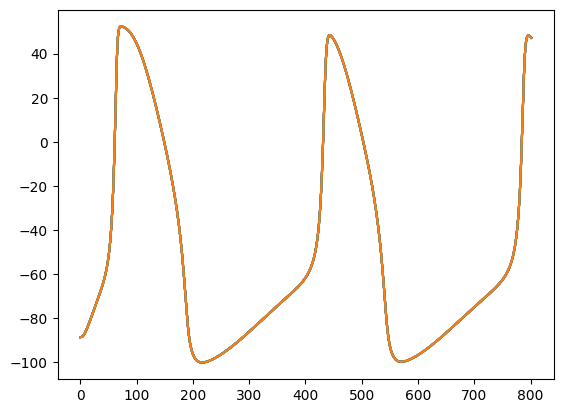

In [277]:
for i in range(ncomps):
    plt.plot(true_outputs[ncomps-1,:])

In [278]:
A = build_axial_matrix(cell)
padded_current = jnp.concatenate([jnp.array([0.]),current])
M = build_eap_M(A, true_distances_CM, 300)
v = true_outputs[:ncomps]
emissions_EAP = compute_eap(v, M, padded_current, 0, true_distances_CM, 300) + tfd.Normal(0,0.001).sample((n_points, n_timesteps), seed=random.PRNGKey(0))

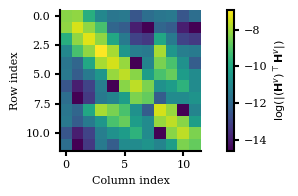

In [283]:
# visualize H.T H

with mpl.rc_context(fname="/Users/ianchristophertanoh/documents/STANFORD/Scott/jaxley/NeurIPS25/matplotlibrc.txt"):

    plt.figure(figsize=(5.5, 2))
    im = plt.imshow(jnp.log(jnp.abs(M.T@M)), origin='upper', aspect='equal')  # top-left is [0,0]
    cb = plt.colorbar(im)
    cb.set_label(r'$\log(|(\mathbf{H}^{v})^\top\mathbf{H}^v|)$')

    # Put ticks at integer indices so it’s obvious which cell is which

    # Draw a box around the top-left (row 0, col 0) cell
    ax = plt.gca()

    # Optional: label that cell

    plt.xlabel('Column index')
    plt.ylabel('Row index')
    plt.tight_layout()
    plt.savefig('mult_heatmap.svg')

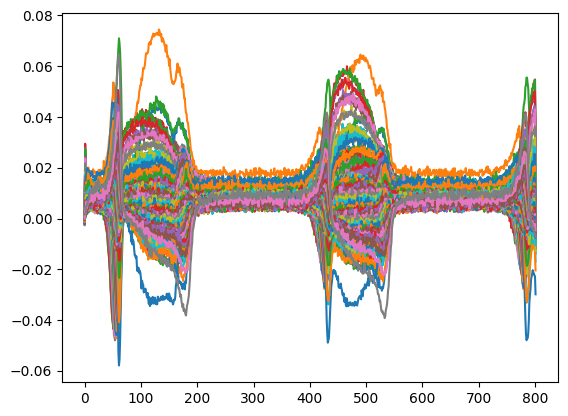

In [9]:
for i in range(len(emissions_EAP)):
    plt.plot(emissions_EAP[i])

In [10]:
HH_params = ['HH_gNa', 'HH_gK', 'HH_gLeak']

In [11]:
dynamics_std = {'v': 0.0001, 'HH_n': 0.00001, 'HH_m': 0.00001, 'HH_h': 0.00001, 'i_HH': 0.01}

In [12]:
Trainer = EKFTrainer(cell = cell,
                     trainable_params = HH_params,
                     dynamics_std = dynamics_std,
                     position_training = "branch model",
                     dt = dt,
                     grid = grid,
                     extracellular_resistivity = 300)

Number of newly added trainable parameters: 1. Total number of trainable parameters: 1
Number of newly added trainable parameters: 1. Total number of trainable parameters: 2
Number of newly added trainable parameters: 1. Total number of trainable parameters: 3
Number of newly added trainable parameters: 1. Total number of trainable parameters: 4
Number of newly added trainable parameters: 1. Total number of trainable parameters: 5
Number of newly added trainable parameters: 1. Total number of trainable parameters: 6
Number of newly added trainable parameters: 1. Total number of trainable parameters: 7
Number of newly added trainable parameters: 1. Total number of trainable parameters: 8
Number of newly added trainable parameters: 1. Total number of trainable parameters: 9
{'gp1': ['HH_gNa', 'HH_gK', 'HH_gLeak'], 'gp2': ['HH_gNa', 'HH_gK', 'HH_gLeak'], 'gp3': ['HH_gNa', 'HH_gK', 'HH_gLeak']}
{'gp1': ['HH_gNa', 'HH_gK', 'HH_gLeak'], 'gp2': ['HH_gNa', 'HH_gK', 'HH_gLeak'], 'gp3': ['HH_gNa

In [23]:
# Make sure these are OFF:
Trainer.position_training = "branch model"
Trainer.noise_training    = None

# Required flags:
Trainer.diagonal = "diagonal"
Trainer.smoother = False
Trainer.obs_std  = 0.001

idx = jnp.array([0, 3, 4, 7, 8, 11])
cell_pos_param = true_cell_positions[idx].ravel()
true_opt_params = jnp.concatenate([Trainer.ref_opt_params,
                                   cell_pos_param])

loss_fn = Trainer._make_loss(emissions_EAP.T, current)
loss_val, aux = loss_fn(true_opt_params)
true_mll = - loss_val
print(float(true_mll))  #for bloc diag = 3564178.7

1114579.9498419515


In [22]:
true_opt_params

Array([ -2.05966361,  -3.90200634,  -8.11157808,  -2.48546199,
        -3.4915204 ,  -7.823846  ,  -2.25216846,  -4.82431107,
        -9.21029037,  12.        ,   0.        ,   0.        ,
        84.        ,   0.        ,   0.        , 120.2535625 ,
        -6.06339063,   0.        , 265.77493753, -42.44373438,
         0.        , 265.77493753,  42.44373438,   0.        ],      dtype=float64)

In [13]:
HH_bounds = {"HH_gLeak": (0.00005, 0.0005),
          "HH_gNa": (0.05, 0.12),
          "HH_gK": (0.005, 0.05)}

init_cond_params = Trainer.sample_cond_params(bounds = HH_bounds, key = 0)

In [17]:
init_pos_params = Trainer.sample_pos_params(radial_sd = 50, key = 0) 

In [18]:
init_pos_params

Array([  14.9371748 ,  -40.80782318,   12.67282486,   76.09392738,
        -65.24974823, -105.07702637,   68.35977512,   44.72651492,
         11.90332508,  288.13858308,    1.13499716,  -21.9676075 ,
         92.55389743,  -32.92319308,  -22.35016441,  337.21766366,
         43.61954269,   33.99568939], dtype=float64)

In [15]:
out = Trainer.train(data = (emissions_EAP.T, current),
            init_cond_params = init_cond_params,
            init_pos_params = init_pos_params,
            obs_std = 0.001,
            lr = 0.3,
            num_epochs = 1000,
            output = ['cond_params', 'cell_positions'],
            diagonal = "diagonal")

EKF train:   1%|▏                           | 6/1000 [06:36<18:14:51, 66.09s/it]


KeyboardInterrupt: 

In [ ]:
inferred_params, true_params = out["cond_params"], Trainer.ref_cond_params

In [ ]:
all_cell_pos = out["cell_positions"]
last_cell_pos = all_cell_pos[-1]

In [230]:
import pickle
with open("Multi_branch_6.pkl", "rb") as f:
    data = pickle.load(f)
    all_inferred_params = data["inferred_params"]
    all_last_cell_pos = data["last_cell_pos"]

In [309]:
import pickle
with open("Multi_branch_diag_1_lr.pkl", "rb") as f:
    data = pickle.load(f)
    all_inferred_params_diag = data["inferred_params"]
    all_last_cell_pos_diag = data["last_cell_pos"]
    #all_mlls = data["mll"]

In [310]:
import pickle
with open("Multi_branch_diag_1_lr_trans.pkl", "rb") as f:
    data = pickle.load(f)
    all_inferred_params_diag_trans = data["inferred_params"]
    all_last_cell_pos_diag_trans = data["last_cell_pos"]
    #all_mlls = data["mll"]

In [326]:
idx = -5
inferred_params = tree_map(lambda x: x[idx], all_inferred_params_diag)
last_cell_pos = all_last_cell_pos_diag[idx]

inferred_params_trans = tree_map(lambda x: x[idx], all_inferred_params_diag_trans)
last_cell_pos_trans = all_last_cell_pos_diag_trans[idx]

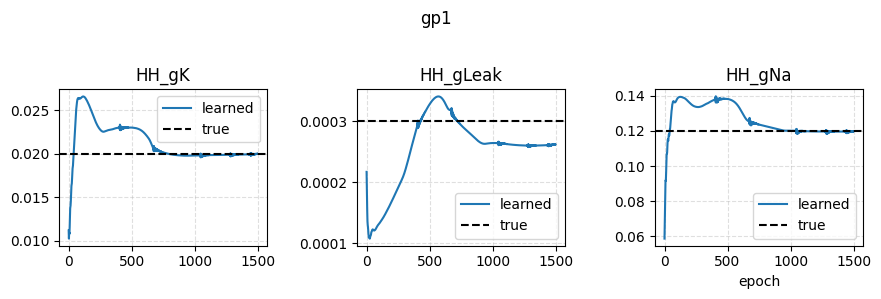

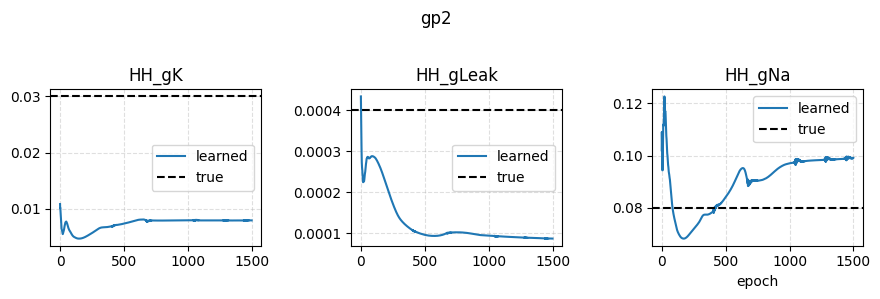

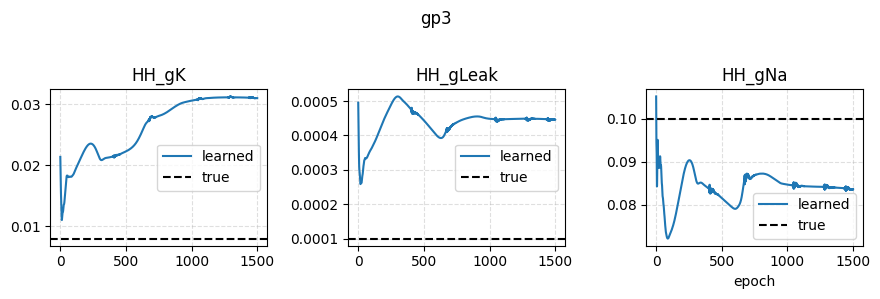

In [329]:
plot_cond_params(params = inferred_params, true_params = Trainer.ref_cond_params)

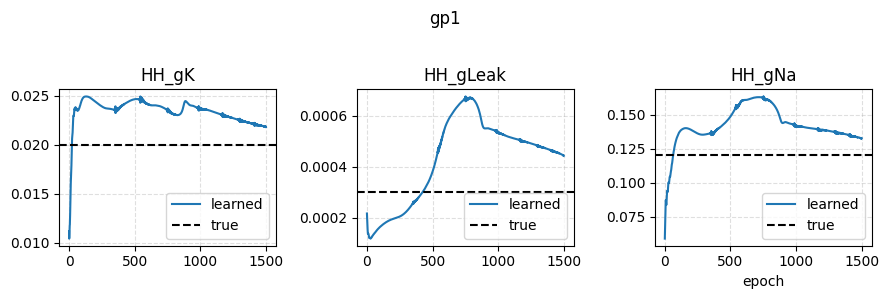

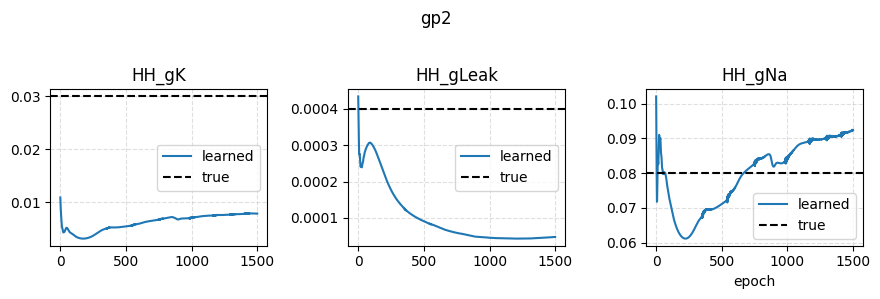

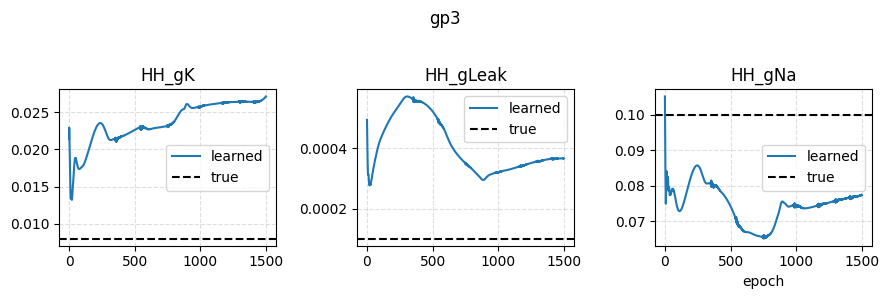

In [328]:
plot_cond_params(params = inferred_params_trans, true_params = Trainer.ref_cond_params)

In [219]:
selected_params_diag = tree_map(lambda x: x[:40], all_inferred_params_diag)
selected_last_cell_pos_diag = all_last_cell_pos_diag[0]

In [266]:
avg_last_cell_pos_diag = jnp.mean(all_last_cell_pos_diag, axis=0)

In [120]:
comp = 11
idx = -2
traj_diag  = Trainer.integrate_from_params(tree_map(lambda x: x[idx,-10], all_inferred_params_diag))[comp]

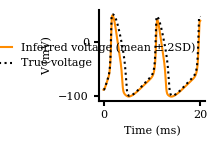

In [262]:
comp = 11

all_trajectories_last_diag = []
for idx in range(40):
    traj_last_diag = Trainer.integrate_from_params(tree_map(lambda x: x[idx,-1], selected_params_diag))[comp]
    all_trajectories_last_diag.append(traj_last_diag)
    
all_trajectories_last_diag = jnp.array(all_trajectories_last_diag)
mean_traj_diag = jnp.mean(all_trajectories_last_diag, axis=0)
std_traj_diag = jnp.std(all_trajectories_last_diag, axis=0)

# Set colors
color_low = 'steelblue'
color_high = 'darkorange'

with mpl.rc_context(fname="/Users/ianchristophertanoh/documents/STANFORD/Scott/jaxley/NeurIPS25/matplotlibrc.txt"):

    # ---------- Low noise figure ----------
    plt.figure(figsize=(5.5/3, 1.5))
    plt.plot(times, mean_traj_diag, color='darkorange', linestyle='-', label='Inferred voltage (mean ± 2SD)')
    plt.plot(times, true_outputs[comp], color="black", linestyle=':', label="True voltage")
    plt.xlabel('Time (ms)')
    plt.ylabel('V (mV)')
    plt.legend()
    plt.tight_layout()
    plt.savefig("volt_mult_diag_11.svg")

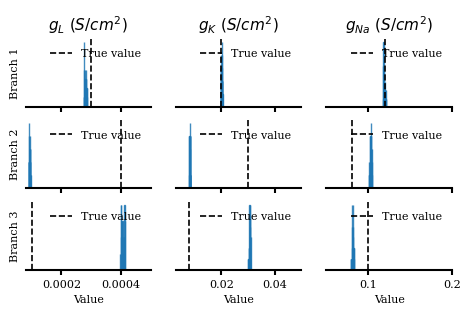

In [228]:
from matplotlib.lines import Line2D

groups = ['gp1', 'gp2', 'gp3']  # rows = branches
conductances = [
    ('HH_gLeak', r'$g_L ~(S/cm^2)$'),
    ('HH_gK',    r'$g_K ~(S/cm^2)$'),
    ('HH_gNa',   r'$g_{Na} ~(S/cm^2)$'),
]  # columns = conductances

with mpl.rc_context(fname="/Users/ianchristophertanoh/documents/STANFORD/Scott/jaxley/NeurIPS25/matplotlibrc.txt"):
    nbranches = len(groups)
    ncols = len(conductances)

    fig, axes = plt.subplots(
        nrows=nbranches, ncols=ncols, figsize=(5.5, 3),
        sharex='col', sharey=False
    )

    # true values: rows = branches, cols = [gL, gK, gNa]
    true_values = jnp.array([
        [0.0003, 0.02,  0.12],
        [0.0004, 0.03,  0.08],
        [0.0001, 0.008, 0.10],
    ])

    bins = 20  # or 'auto'
    for row, group in enumerate(groups):            # row = branch
        for col, (key, label) in enumerate(conductances):  # col = conductance
            gp_params = selected_params_diag[group]
            last_vals = jnp.array(gp_params[key])[:, -1]   # final epoch per sim

            ax = axes[row, col]
            ax.hist(last_vals, bins=bins, density=False, alpha=0.85, edgecolor='C0')
            # dashed true value line WITH label so legend can be shown on each subplot
            ax.axvline(true_values[row, col], color='black', linestyle='--', linewidth=1.2,
                       label='True value')

            # remove y “counts” visuals
            ax.set_yticks([])
            ax.spines['left'].set_visible(False)

            # per-subplot legend
            ax.legend(loc='upper right', frameon=False, fontsize=8, handlelength=2.0)

            # x-axis label only on bottom row
            if row == nbranches - 1:
                ax.set_xlabel('Value')

    # row labels: "Branch 1/2/3"
    for row in range(nbranches):
        axes[row, 0].set_ylabel(f'Branch {row+1}')

    # column titles = conductance names
    for col, (_, label) in enumerate(conductances):
        axes[0, col].set_title(label, fontsize=11)

    # tidy spines
    for ax in axes.flat:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    # x-limits per conductance column
    x_lims = [
        (0.00008, 0.0005),  # g_L
        (0.003,    0.05),   # g_K
        (0.05,     0.2),    # g_Na
    ]
    for col, (xmin, xmax) in enumerate(x_lims):
        for row in range(nbranches):
            axes[row, col].set_xlim(xmin, xmax)

    plt.savefig("hist_cond_mult_diag.svg", bbox_inches='tight')

In [231]:
selected_idx = jnp.array([0,3,4,5,6,7,8,11,12,13,14,17,18,20,27,28,42,45,47,48,54,55,56,57,61,63,64,66,74,75,
                         76,77,78,80,81,83,84,95,96,97])

In [232]:
selected_params = tree_map(lambda x: x[selected_idx], all_inferred_params)
selected_last_cell_pos = all_last_cell_pos[78]

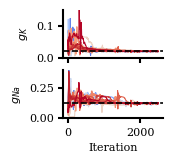

In [233]:
gp1_params = selected_params['gp1']

with mpl.rc_context(fname="/Users/ianchristophertanoh/documents/STANFORD/Scott/jaxley/NeurIPS25/matplotlibrc.txt"):
    num_epochs = 2500
    iterations = jnp.arange(num_epochs)

    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(1.5, 1.5), sharex=True)
    colors = plt.cm.coolwarm(jnp.linspace(0, 1, len(selected_idx)))

    # Plot only g_K and g_Na
    for i in range(len(selected_idx)):
        color = colors[i]
        gK  = gp1_params['HH_gK'][i]
        gNa = gp1_params['HH_gNa'][i]
        axes[0].plot(iterations, gK,  color=color, linewidth=.8)
        axes[1].plot(iterations, gNa, color=color, linewidth=.8)

    # True values and labels
    true_values = [0.02, 0.12]
    y_labels    = [r"$g_K$", r"$g_{Na}$"]
    y_limits    = [(0, 0.15), (0, 0.4)]  # tweak as needed

    for ax, y_true, ylab, ylim in zip(axes, true_values, y_labels, y_limits):
        ax.axhline(y=y_true, color='black', linestyle='--', linewidth=1.2)
        ax.set_ylabel(ylab)
        ax.set_ylim(ylim)

    # Only one x-label (bottom)
    axes[-1].set_xlabel('Iteration')
    # Hide x tick labels on the top axis
    for ax in axes[:-1]:
        ax.label_outer()

    fig.tight_layout(pad=0.3, h_pad=0.15)
    plt.savefig("mult_traces.svg", bbox_inches='tight')

In [ ]:
gp1_params = selected_params['gp3']

with mpl.rc_context(fname="/Users/ianchristophertanoh/documents/STANFORD/Scott/jaxley/NeurIPS25/matplotlibrc.txt"):
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(1.5, 1.5))  # no sharex

    # final values per simulation
    gL_last  = jnp.array(gp1_params['HH_gLeak'])[:, -1]
    gK_last  = jnp.array(gp1_params['HH_gK'])[:,   -1]
    gNa_last = jnp.array(gp1_params['HH_gNa'])[:,  -1]

    data = [
        (gL_last,  r"$g_L$",   0.0001),
        (gK_last,  r"$g_K$",   0.008),
        (gNa_last, r"$g_{Na}$", 0.10),
    ]

    # choose bins and ticks per subplot
    bins = [20, 20, 20]
    xlims = [
        (8e-5, 1.2e-4),  # g_L
        (0.007, 0.009),  # g_K
        (0.08,  0.12),   # g_Na
    ]
    xticks = [
        [8e-5, 1e-4, 1.2e-4],   # g_L
        [0.007, 0.008, 0.009],  # g_K
        [0.08, 0.10, 0.12],     # g_Na
    ]

    for idx, (ax, (vals, row_label, true_val), B, (xmin, xmax), xtk) in enumerate(
        zip(axes, data, bins, xlims, xticks)
    ):
        ax.hist(vals, bins=B, density=False, alpha=0.85, edgecolor='C0')
        ax.axvline(true_val, color='black', linestyle='--', linewidth=1.0, label='True value')
        ax.legend(loc='upper right', frameon=False, fontsize=7, handlelength=2.0)

        # per-plot axis formatting
        ax.set_xlim(xmin, xmax)
        ax.set_xticks(xtk)
        ax.set_yticks([])                 # hide counts ticks
        ax.spines['left'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

        # ROW NAME = conductance label
        ax.set_ylabel(row_label)

        # only bottom subplot gets an x-axis label
        if idx == 2:
            ax.set_xlabel('Value')

    fig.tight_layout(pad=0.3, h_pad=0.28)
    plt.savefig("mult_hists.svg", bbox_inches='tight')

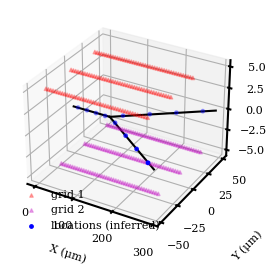

In [270]:
with mpl.rc_context(fname="/Users/ianchristophertanoh/documents/STANFORD/Scott/jaxley/NeurIPS25/matplotlibrc.txt"):

    fig = plt.figure(figsize=(3., 3.))
    ax = fig.add_subplot(111, projection='3d')

    # Plot compartments
    cell.vis(ax=ax, color="black")

    # Plot grid points with smaller markers
    ax.scatter(grid1[:, 0], grid1[:, 1], grid1[:, 2], c='r', marker='^', s=6, label='grid 1', alpha=0.3)
    ax.scatter(grid2[:, 0], grid2[:, 1], grid2[:, 2], c='m', marker='^', s=6, label='grid 2', alpha=0.3)

    # Plot inferred compartments with smaller markers
    ax.scatter(avg_last_cell_pos_diag[:, 0], avg_last_cell_pos_diag[:, 1], avg_last_cell_pos_diag[:, 2], c='b', s=6, label='locations (inferred)')

    # Axes labels and legend
    ax.set_xlabel("X (μm)")
    ax.set_ylabel("Y (μm)", labelpad=15)
    ax.set_zlabel("Z (μm)")
    ax.legend()
    plt.savefig("mult_pos_diag.svg")

In [ ]:
with mpl.rc_context(fname="/Users/ianchristophertanoh/documents/STANFORD/Scott/jaxley/NeurIPS25/matplotlibrc.txt"):

    fig = plt.figure(figsize=(2., 1.7))
    ax = fig.add_subplot(111, projection='3d')

    # Plot compartments
    cell.vis(ax=ax, color="black")

    # Plot grid points with smaller markers
    ax.scatter(grid1[:, 0], grid1[:, 1], grid1[:, 2], c='r', marker='^', s=6, label='grid 1', alpha=0.3)
    ax.scatter(grid2[:, 0], grid2[:, 1], grid2[:, 2], c='m', marker='^', s=6, label='grid 2', alpha=0.3)

    # Plot inferred compartments with smaller markers
    ax.scatter(selected_last_cell_pos[:, 0], selected_last_cell_pos[:, 1], selected_last_cell_pos[:, 2], c='b', s=6, label='locations (inferred)')

    # Axes labels and legend
    ax.set_xlabel("X (μm)")
    ax.set_ylabel("Y (μm)", labelpad=15)
    ax.set_zlabel("Z (μm)")
    ax.legend()
    plt.savefig("mult_pos.svg")


In [ ]:
#PLOT TRAJECTORIES
comp = 11

all_trajectories_last = []
for idx in selected_idx:
    traj_last = Trainer.integrate_from_params(tree_map(lambda x: x[idx,-1], selected_params))[comp]
    all_trajectories_last.append(traj_last)
    
init_traj_last = Trainer.integrate_from_params(tree_map(lambda x: x[0,0], selected_params))[comp]

all_trajectories_last = jnp.array(all_trajectories_last)
mean_traj = jnp.mean(all_trajectories_last, axis=0)
std_traj = jnp.std(all_trajectories_last, axis=0)

In [ ]:
# Set colors
color_low = 'steelblue'
color_high = 'darkorange'

with mpl.rc_context(fname="/Users/ianchristophertanoh/documents/STANFORD/Scott/jaxley/NeurIPS25/matplotlibrc.txt"):

    # ---------- Low noise figure ----------
    plt.figure(figsize=(5.5/3, 1.5))
    plt.plot(times, mean_traj, color=color_low, linestyle='-', label='Inferred voltage')
    plt.plot(times, init_traj_last, color="green", label="Initial guess")
    plt.plot(times, true_outputs[comp], color="black", linestyle=':', label="True voltage")
    plt.xlabel('Time (ms)')
    plt.ylabel('V (mV)')
    plt.legend()
    plt.tight_layout()
    plt.savefig("volt_mult.svg")

In [ ]:
groups = ['gp1', 'gp2', 'gp3']  # columns = branches
conductances = [
    ('HH_gLeak', r'$g_L ~(S/cm^2)$'),
    ('HH_gK',    r'$g_K ~(S/cm^2)$'),
    ('HH_gNa',   r'$g_{Na} ~(S/cm^2)$'),
]

with mpl.rc_context(fname="/Users/ianchristophertanoh/documents/STANFORD/Scott/jaxley/NeurIPS25/matplotlibrc.txt"):
    nbranches = len(groups)
    nrows = len(conductances)

    fig, axes = plt.subplots(nrows=nrows, ncols=nbranches, figsize=(5.5, 3),
                              sharex=True, sharey='row')

    colors = plt.cm.coolwarm(jnp.linspace(0, 1, len(selected_idx)))
    num_epochs = 2500
    iterations = jnp.arange(num_epochs)

    # true values: rows = branches, cols = [gL, gK, gNa]
    true_values = jnp.array([
        [0.0003, 0.02,  0.12],
        [0.0004, 0.03,  0.08],
        [0.0001, 0.008, 0.10],
    ])

    # plot traces
    for i_run, color in enumerate(colors):
        for col, group in enumerate(groups):
            gp_params = selected_params[group]
            traces = [
                gp_params['HH_gLeak'][i_run],
                gp_params['HH_gK'][i_run],
                gp_params['HH_gNa'][i_run],
            ]
            for row, (key, ylab) in enumerate(conductances):
                axes[row, col].plot(iterations, traces[row], linewidth=.8, color=color)

    # decorations: true lines, labels, titles, per-axes legends
    for row, (key, ylab) in enumerate(conductances):
        for col in range(nbranches):
            # dashed true value line WITH label so legend shows in each subplot
            axes[row, col].axhline(y=true_values[col, row], color='black',
                                   linestyle='--', linewidth=1.2, label='True value')
            if row == nrows - 1:
                axes[row, col].set_xlabel('Iteration')

            # per-subplot legend (only the dashed line has a label)
            axes[row, col].legend(loc='upper right', frameon=False, fontsize=8, handlelength=2.0)

        axes[row, 0].set_ylabel(ylab)

    # column titles = branches
    for col in range(nbranches):
        axes[0, col].set_title(f'Branch {col+1}')

    # optional: lighter frames and hide redundant x tick labels
    for row in range(nrows - 1):
        for col in range(nbranches):
            axes[row, col].label_outer()
    for ax in axes.flat:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    # y-axis limits for each conductance row
    y_lims = [
        (-0.001, 0.005),  # g_L
        (0,      0.15),   # g_K
        (0,      0.43),   # g_Na
    ]
    for row, (ymin, ymax) in enumerate(y_lims):
        for col in range(nbranches):
            axes[row, col].set_ylim(ymin, ymax)

    plt.savefig("cond_mult.svg", bbox_inches='tight')


In [ ]:
from matplotlib.lines import Line2D

groups = ['gp1', 'gp2', 'gp3']  # rows = branches
conductances = [
    ('HH_gLeak', r'$g_L ~(S/cm^2)$'),
    ('HH_gK',    r'$g_K ~(S/cm^2)$'),
    ('HH_gNa',   r'$g_{Na} ~(S/cm^2)$'),
]  # columns = conductances

with mpl.rc_context(fname="/Users/ianchristophertanoh/documents/STANFORD/Scott/jaxley/NeurIPS25/matplotlibrc.txt"):
    nbranches = len(groups)
    ncols = len(conductances)

    fig, axes = plt.subplots(
        nrows=nbranches, ncols=ncols, figsize=(5.5, 3),
        sharex='col', sharey=False
    )

    # true values: rows = branches, cols = [gL, gK, gNa]
    true_values = jnp.array([
        [0.0003, 0.02,  0.12],
        [0.0004, 0.03,  0.08],
        [0.0001, 0.008, 0.10],
    ])

    bins = 20  # or 'auto'
    for row, group in enumerate(groups):            # row = branch
        for col, (key, label) in enumerate(conductances):  # col = conductance
            gp_params = selected_params[group]
            last_vals = jnp.array(gp_params[key])[:, -1]   # final epoch per sim

            ax = axes[row, col]
            ax.hist(last_vals, bins=bins, density=False, alpha=0.85, edgecolor='C0')
            # dashed true value line WITH label so legend can be shown on each subplot
            ax.axvline(true_values[row, col], color='black', linestyle='--', linewidth=1.2,
                       label='True value')

            # remove y “counts” visuals
            ax.set_yticks([])
            ax.spines['left'].set_visible(False)

            # per-subplot legend
            ax.legend(loc='upper right', frameon=False, fontsize=8, handlelength=2.0)

            # x-axis label only on bottom row
            if row == nbranches - 1:
                ax.set_xlabel('Value')

    # row labels: "Branch 1/2/3"
    for row in range(nbranches):
        axes[row, 0].set_ylabel(f'Branch {row+1}')

    # column titles = conductance names
    for col, (_, label) in enumerate(conductances):
        axes[0, col].set_title(label, fontsize=11)

    # tidy spines
    for ax in axes.flat:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    # x-limits per conductance column
    x_lims = [
        (0.00008, 0.0005),  # g_L
        (0.003,    0.05),   # g_K
        (0.05,     0.2),    # g_Na
    ]
    for col, (xmin, xmax) in enumerate(x_lims):
        for row in range(nbranches):
            axes[row, col].set_xlim(xmin, xmax)

    plt.savefig("hist_cond_mult.svg", bbox_inches='tight')

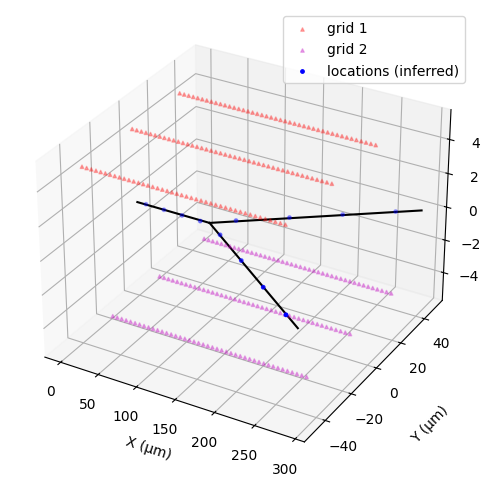

In [267]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot compartments
cell.vis(ax=ax, color="black")

# Plot grid points with smaller markers
ax.scatter(grid1[:, 0], grid1[:, 1], grid1[:, 2], c='r', marker='^', s=6, label='grid 1', alpha=0.3)
ax.scatter(grid2[:, 0], grid2[:, 1], grid2[:, 2], c='m', marker='^', s=6, label='grid 2', alpha=0.3)

# Plot inferred compartments with smaller markers
ax.scatter(last_cell_pos[:, 0], last_cell_pos[:, 1], last_cell_pos[:, 2], c='b', s=6, label='locations (inferred)')

# Axes labels and legend
ax.set_xlabel("X (μm)")
ax.set_ylabel("Y (μm)", labelpad=15)
ax.set_zlabel("Z (μm)")
ax.legend()

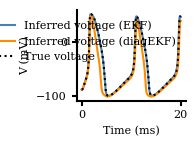

In [238]:
comp = 11

all_trajectories_last_EKF = []
for idx in selected_idx:
    traj_last_EKF = Trainer.integrate_from_params(tree_map(lambda x: x[idx,-1], selected_params))[comp]
    all_trajectories_last_EKF.append(traj_last_EKF)
    
all_trajectories_last_EKF = jnp.array(all_trajectories_last_EKF)
mean_traj_EKF = jnp.mean(all_trajectories_last_EKF, axis=0)
std_traj_EKF = jnp.std(all_trajectories_last_EKF, axis=0)

all_trajectories_last_diag = []
for idx in range(40):
    traj_last_diag = Trainer.integrate_from_params(tree_map(lambda x: x[idx,-1], selected_params_diag))[comp]
    all_trajectories_last_diag.append(traj_last_diag)
    
all_trajectories_last_diag = jnp.array(all_trajectories_last_diag)
mean_traj_diag = jnp.mean(all_trajectories_last_diag, axis=0)
std_traj_diag = jnp.std(all_trajectories_last_diag, axis=0)

# Set colors
color_low = 'steelblue'
color_high = 'darkorange'

with mpl.rc_context(fname="/Users/ianchristophertanoh/documents/STANFORD/Scott/jaxley/NeurIPS25/matplotlibrc.txt"):

    # ---------- Low noise figure ----------
    plt.figure(figsize=(5.5/3, 1.5))
    plt.plot(times, mean_traj_EKF, color=color_low, linestyle='-', label='Inferred voltage (EKF)')
    plt.plot(times, mean_traj_diag, color=color_high, linestyle='-', label='Inferred voltage (diagEKF)')
    plt.plot(times, true_outputs[comp], color="black", linestyle=':', label="True voltage")
    plt.xlabel('Time (ms)')
    plt.ylabel('V (mV)')
    plt.legend()
    plt.tight_layout()
    plt.savefig("volt_mult_ekf_vs_diag.svg")